In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(test_set, batch_size=128, shuffle=True)


In [3]:
def add_noisy_patch(images):
    noisy_image = images.clone()
    batch_size,_,h,w = noisy_image.shape

    for i in range(batch_size):
        x = np.random.randint(0,h-8)
        y = np.random.randint(0,w-8)

        noisy_image[i,0,x:x+8,y:y+8] =0.5
    return noisy_image 


In [4]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,28*28),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = self.encoder(x)
        return self.decoder(x)
        

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenoisingAutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
criterion = nn.MSELoss()

In [8]:
epochs = 50
for epoch in range(epochs):
    overall_loss = 0
    for imgs, _ in trainloader:
        noisy_imgs = add_noisy_patch(imgs).to(device)
        clean_imgs = imgs.view(imgs.size(0), -1).to(device)
        noisy_imgs = noisy_imgs.view(noisy_imgs.size(0), -1).to(device)

        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        overall_loss +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = overall_loss/len(trainloader)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/50], Loss: 0.0408
Epoch [2/50], Loss: 0.0339
Epoch [3/50], Loss: 0.0301
Epoch [4/50], Loss: 0.0282
Epoch [5/50], Loss: 0.0271
Epoch [6/50], Loss: 0.0262
Epoch [7/50], Loss: 0.0254
Epoch [8/50], Loss: 0.0243
Epoch [9/50], Loss: 0.0233
Epoch [10/50], Loss: 0.0227
Epoch [11/50], Loss: 0.0221
Epoch [12/50], Loss: 0.0216
Epoch [13/50], Loss: 0.0212
Epoch [14/50], Loss: 0.0208
Epoch [15/50], Loss: 0.0204
Epoch [16/50], Loss: 0.0201
Epoch [17/50], Loss: 0.0198
Epoch [18/50], Loss: 0.0196
Epoch [19/50], Loss: 0.0193
Epoch [20/50], Loss: 0.0191
Epoch [21/50], Loss: 0.0190
Epoch [22/50], Loss: 0.0189
Epoch [23/50], Loss: 0.0187
Epoch [24/50], Loss: 0.0185
Epoch [25/50], Loss: 0.0184
Epoch [26/50], Loss: 0.0183
Epoch [27/50], Loss: 0.0182
Epoch [28/50], Loss: 0.0181
Epoch [29/50], Loss: 0.0179
Epoch [30/50], Loss: 0.0179
Epoch [31/50], Loss: 0.0177
Epoch [32/50], Loss: 0.0176
Epoch [33/50], Loss: 0.0176
Epoch [34/50], Loss: 0.0175
Epoch [35/50], Loss: 0.0174
Epoch [36/50], Loss: 0.0174
E

In [10]:
model.eval()
dataiter = iter(testloader)
image,_ = next(dataiter)
noisy_image = add_noisy_patch(image).view(-1,28*28).to(device)
with torch.no_grad():
    reconstructed_image = model(noisy_image).cpu().detach()

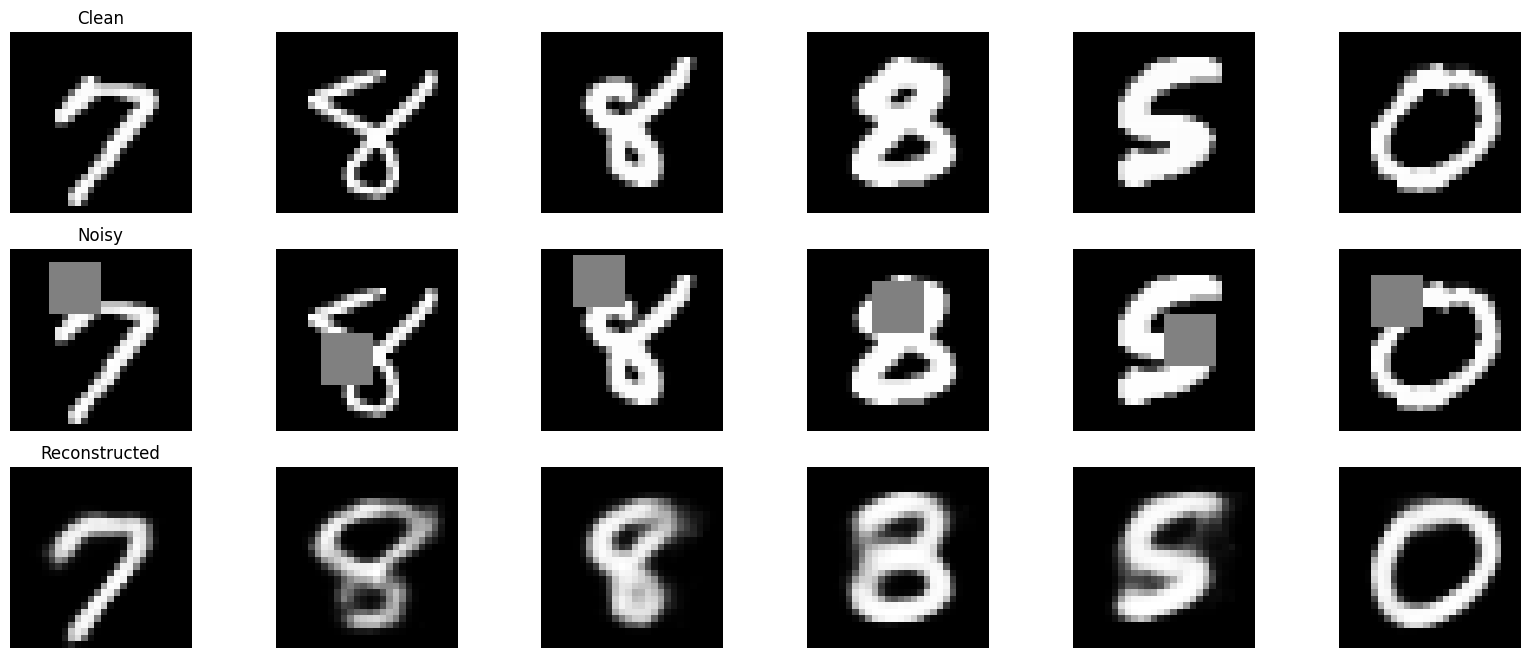

In [22]:
images = image.numpy()
noisy_images = noisy_image.cpu().numpy()
reconstructed_images = reconstructed_image.view(-1, 1, 28, 28).numpy()

n = 6
plt.figure(figsize=(20,8))
for i in range(n):   
    # clean
    ax = plt.subplot(3, n, i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i==0: 
        ax.set_title("Clean")

    # noisy
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(noisy_images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i==0: 
        ax.set_title("Noisy")
        
    # reconstructed
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(reconstructed_images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i==0: 
        ax.set_title("Reconstructed")
        
    
plt.show()